##### Setup

In [320]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
import re
from datetime import datetime
import sys
from pathlib import Path

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [321]:
# Load in preprocessed data
foraging_filepath = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'

foraging_df = pd.read_csv(foraging_filepath)

# Drop extraneous subject
foraging_df = foraging_df[foraging_df['subject_id'] != 111111]

foraging_df.sort_values(['subject_id', 'session_date', 'trial'], inplace=True)

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_38223/3084687691.py:4: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  foraging_df = pd.read_csv(foraging_filepath)


In [322]:
# Identify block transitions
block_transitions = ((foraging_df['reward_probabilityL'].shift() != foraging_df['reward_probabilityL']) | 
                    (foraging_df['reward_probabilityR'].shift() != foraging_df['reward_probabilityR'])).astype(int)

# Handle first trials of each session
first_rows_mask = ~foraging_df[['subject_id', 'session_date']].duplicated()
block_transitions.loc[first_rows_mask] = 1

# Create unique block numbers within each session
foraging_df['block'] = block_transitions.groupby([foraging_df['subject_id'], 
                                                foraging_df['session_date']]).cumsum()
foraging_df.head()

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval,block
1447552,0,2.0,False,False,False,False,0.80,0.088889,0.711111,0.909618,...,NaN,NaN,NaN,False,False,567890,2024-11-01,0.0,0.0,1
1447553,1,2.0,False,False,False,True,0.80,0.088889,0.711111,0.807069,...,NaN,NaN,NaN,False,False,567890,2024-11-01,0.0,0.0,1
868421,0,2.0,False,False,True,False,0.80,0.711111,0.088889,0.426309,...,NaN,NaN,NaN,False,False,641733,2024-01-24,0.0,0.0,1
868422,1,2.0,False,False,True,False,0.80,0.711111,0.088889,0.554599,...,NaN,NaN,NaN,False,False,641733,2024-01-24,0.0,0.0,1
142214,0,1.0,False,False,False,False,0.45,0.400000,0.050000,0.925068,...,NaN,0.43744,0.43744,False,False,684039,2023-10-25,NaN,NaN,1


In [323]:
# Define chosen metric difference function

def chosen_metric_difference(df, global_calc=True):
    """
    Current difference calculation method
    """
    grouped = df.groupby(['subject_id', 'session_date'])
    results = []
    
    for (subject, date), session_df in grouped:
        session_df['probability_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityL'],
            session_df['reward_probabilityR']
        )
        session_df['probability_not_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityR'],
            session_df['reward_probabilityL']
        )
        
        if global_calc:
            difference = session_df['probability_chosen'] - session_df['probability_not_chosen']
            
            p_larger_global = max(session_df['probability_chosen'].max(), 
                                session_df['probability_not_chosen'].max())
            p_smaller_global = min(session_df['probability_chosen'].min(), 
                                 session_df['probability_not_chosen'].min())
            
            if p_larger_global == p_smaller_global:
                continue
                
            final_metric = difference.mean() / (p_larger_global - p_smaller_global)
            
            results.append({
                'subject_id': subject,
                'session_date': date,
                'chosen_metric': final_metric,
            })
            
        else:
            block_metrics = []
            
            for block_num, block_df in session_df.groupby('block'):
                difference = block_df['probability_chosen'] - block_df['probability_not_chosen']
                
                p_larger_block = max(block_df['probability_chosen'].max(),
                                   block_df['probability_not_chosen'].max())
                p_smaller_block = min(block_df['probability_chosen'].min(),
                                    block_df['probability_not_chosen'].min())
                
                if p_larger_block == p_smaller_block:
                    continue
                    
                block_metric = difference.mean() / (p_larger_block - p_smaller_block)
                block_metrics.append(block_metric)
            
            if block_metrics:
                results.append({
                    'subject_id': subject,
                    'session_date': date,
                    'chosen_metric': np.mean(block_metrics),
                })
    
    return pd.DataFrame(results)

In [324]:
# Create chosen metric DataFrames

diff_global = chosen_metric_difference(foraging_df, global_calc=True)
diff_local = chosen_metric_difference(foraging_df, global_calc=False)

# Compare results
diff_all = pd.concat([
    diff_global.assign(method='diff_global'),
    diff_local.assign(method='diff_local')
])

In [325]:
# Load in session level metrics 

session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_38223/1577903200.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')


In [347]:
session_metrics.sort_values(['subject_id', 'session_date'], inplace=True)
session_metrics.loc[:, ['subject_id', 'session_date', 'session']]

,subject_id,session_date,session
8915,447921,2019-09-11,1.0
8906,447921,2019-09-12,2.0
8905,447921,2019-09-13,3.0
8898,447921,2019-09-14,4.0
8897,447921,2019-09-15,5.0
...,...,...,...
71,764791,2024-11-04,1.0
28,764791,2024-11-06,2.0
70,769887,2024-11-04,1.0
27,769887,2024-11-06,2.0


##### preprocessing

In [343]:
# Merge calculated metrics with session metrics 

diff_all['session_date'] = diff_all['session_date'].astype('datetime64[ns]')
diff_global['session_date'] = diff_global['session_date'].astype('datetime64[ns]')
diff_local['session_date'] = diff_local['session_date'].astype('datetime64[ns]')

diff_all_merged = bu.merge_dataframes_subject_id(diff_all, session_metrics)
diff_global_merged = bu.merge_dataframes_subject_id(diff_global, session_metrics)
diff_local_merged = bu.merge_dataframes_subject_id(diff_local, session_metrics)

pd.set_option('future.no_silent_downcasting', True)

# Remove extraneous columns

extraneous_columns = [ 'nwb_suffix',
 'rig',
 'user_name',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'lickspout_movement_range_x',
 'lickspout_movement_range_y',
 'lickspout_movement_range_z',
 'lickspout_initial_pos_x',
 'lickspout_initial_pos_y',
 'lickspout_initial_pos_z',
 'lickspout_median_pos_x',
 'lickspout_median_pos_y',
 'lickspout_median_pos_z',
 'has_video',
 'has_ephys',
 'old_bpod_session',
 'h2o',
 'institute',
 'rig_type',
 'room',
 'hardware',
 'data_source',
'location',
 'session_name',
 'creation_time',
 'co_data_asset_ID',
 'subject_genotype',
 'fiber_probes',
 'injections',
 'task_type',
 'virus',
 'NM_recorded',
 'results',
 'results_location',
 'session_time',
 'docDB_status'
 ]

diff_all_merged = bu.remove_columns(diff_all_merged, extraneous_columns)
diff_global_merged = bu.remove_columns(diff_global_merged, extraneous_columns)
diff_local_merged = bu.remove_columns(diff_local_merged, extraneous_columns)

# Clean DataFrames

diff_all_merged = bu.clean_dataframe(diff_all_merged, threshold=0.1)
diff_global_merged = bu.clean_dataframe(diff_global_merged, threshold=0.1)
diff_local_merged = bu.clean_dataframe(diff_local_merged, threshold=0.1)

# Add session column 'new_sesssion

diff_all_comp= bu.add_session_column(diff_all_merged)
diff_global_comp = bu.add_session_column(diff_global_merged)
diff_local_comp = bu.add_session_column(diff_local_merged)



Original DataFrame shape: (8996, 114)
Cleaned DataFrame shape: (8838, 114)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)


In [344]:
diff_all_comp.loc[:, ['subject_id', 'session_date', 'session', 'new_session']]

,subject_id,session_date,session,new_session
0,684039,2023-10-25,6.0,1
4498,684039,2023-10-25,6.0,1
1,684039,2023-10-26,7.0,2
4499,684039,2023-10-26,7.0,2
2,684039,2023-10-27,8.0,3
...,...,...,...,...
8993,769887,2024-11-04,1.0,1
4496,769887,2024-11-06,2.0,2
8994,769887,2024-11-06,2.0,2
4497,769888,2024-11-04,1.0,1


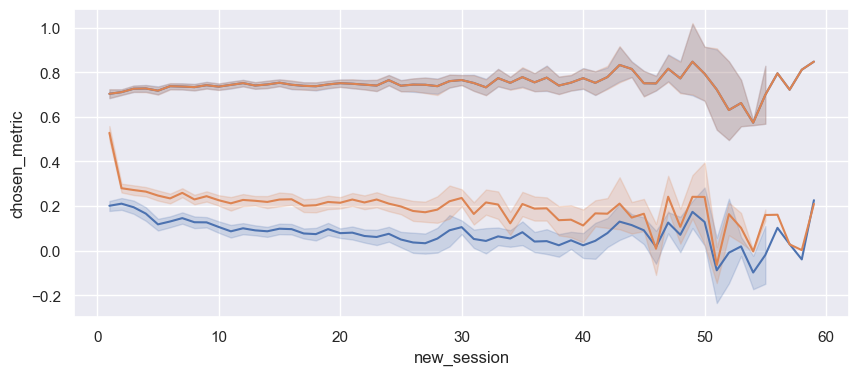

In [348]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_all_comp, x='new_session', y='chosen_metric', hue='method')
sns.lineplot(diff_all_comp, x='new_session', y='foraging_eff_random_seed', hue='method')
plt.legend().remove()

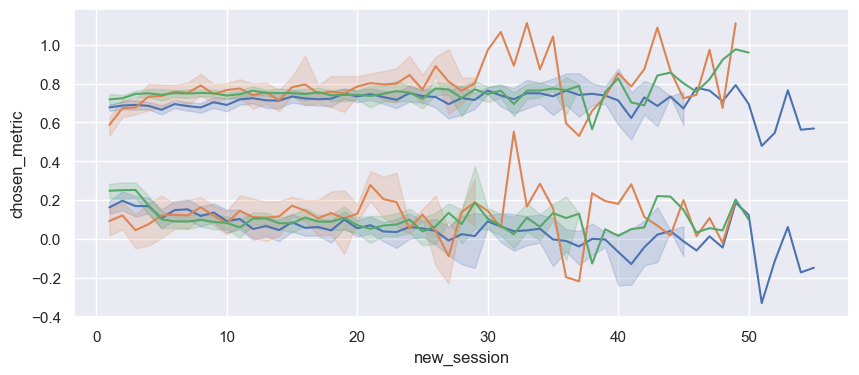

In [349]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_global_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_global_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

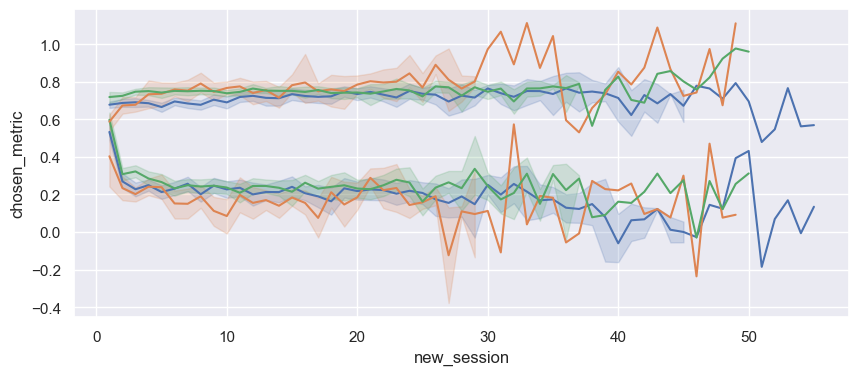

In [350]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_local_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_local_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

##### filtering

In [364]:
# Explore version

version_dict = bu.analyze_column_distribution(diff_all_comp, 'curriculum_version')
version_dict


{'value_counts': curriculum_version
 2.3                 2074
 2.2                  790
 1.0                  742
 2.3.1rwdDelay159     712
 2.2.1rwdDelay159     634
 2.0                  306
 2.1rwdDelay159       266
 2.2rwdDelay159       170
 2.1                  146
 2.3rwdDelay159       104
 0.1                   56
 0.1                    2
 Name: count, dtype: int64,
 'percentages': curriculum_version
 2.3                 34.555148
 2.2                 13.162279
 1.0                 12.362546
 2.3.1rwdDelay159    11.862712
 2.2.1rwdDelay159    10.563146
 2.0                  5.098301
 2.1rwdDelay159       4.431856
 2.2rwdDelay159       2.832389
 2.1                  2.432522
 2.3rwdDelay159       1.732756
 0.1                  0.933022
 0.1                  0.033322
 Name: proportion, dtype: float64,
 'total_count': 8838,
 'unique_values': 12,
 'most_common': ('2.3', 2074),
 'least_common': ('0.1', 2)}

In [365]:
# Filter by curriculum version
filtered_local = bu.filter_by_column(diff_local_comp, 'curriculum_version', '2.3')
filtered_global = bu.filter_by_column(diff_global_comp, 'curriculum_version', '2.3')
filtered_all = bu.filter_by_column(diff_all_comp, 'curriculum_version', '2.3')

# Filter by stage
filtered_local = bu.filter_by_column(filtered_local, 'current_stage_actual', 'STAGE_FINAL')
filtered_global = bu.filter_by_column(filtered_global, 'current_stage_actual', 'STAGE_FINAL')
filtered_all = bu.filter_by_column(filtered_all, 'current_stage_actual', 'STAGE_FINAL')

# Filter by task
filtered_local = bu.filter_by_column(filtered_local, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_global = bu.filter_by_column(filtered_global, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_all = bu.filter_by_column(filtered_all, 'task', 'Uncoupled Baiting', reset_sessions=True)

In [366]:
filtered_all['task'].unique()

array(['Uncoupled Baiting'], dtype=object)

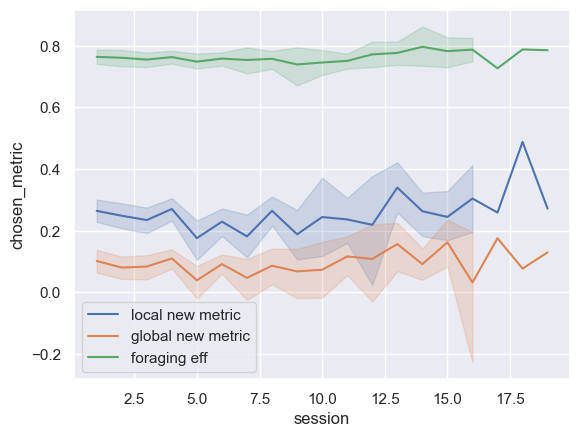

In [367]:
sns.lineplot(filtered_local, x='session', y='chosen_metric', label='local new metric')
sns.lineplot(filtered_global, x='session', y='chosen_metric', label='global new metric')
sns.lineplot(filtered_local, x='session', y='foraging_eff_random_seed', label='foraging eff')

plt.legend()